In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import padsequence
import tensorflow as tf
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [11]:
data = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

In [12]:
data


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


#Preprocessing

In [16]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop rows with missing reviews
    missing_review_rows = df[df['Review Text'].isna()].index
    df = df.drop(missing_review_rows, axis=0).reset_index(drop=True)
    
    
    # Use only the review and rating column
    y = df['Rating']
    X = df['Review Text']
    
    
    # Make y a binary target
    y = y.apply(lambda x: 1 if x == 5 else 0)
    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    
    # Learn the vocabulary
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    
    
    # Find the size of the vocabulary
    vocab_length = len(tokenizer.word_index) + 1
    print("Vocab length:", vocab_length)
    
    
    # Convert review texts into sequences of integers
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    
    # Find the maximum sequence length
    max_seq_length = np.max(list(map(lambda x: len(x), X_train)))
    print("Maximum sequence length:", max_seq_length)
    
    
    # Pad the sequences to by uniform length
    X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post')
    
    
    return X_train, X_test, y_train, y_test, vocab_length, max_seq_length

In [17]:
X_train, X_test, y_train, y_test, VOCAB_LENGTH, MAX_SEQ_LENGTH = preprocess_inputs(data)

Vocab length: 12751
Maximum sequence length: 116


In [18]:
X_train.shape


(15848, 116)

In [19]:
X_test.shape

(6793, 116)

****Training****

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 116)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 116, 128)             1632128   ['input_1[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 14848)                0         ['embedding[0][0]']           
                                                                                                  
 gru (GRU)                   (None, 256)                  296448    ['embedding[0][0]']           
                                                                                              

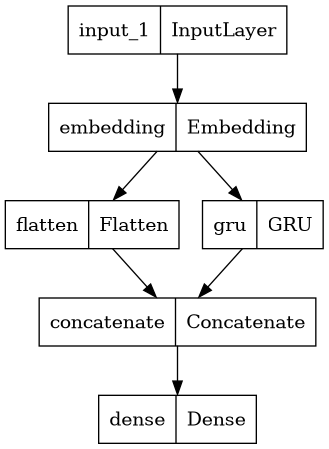

In [20]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

word_embedding = tf.keras.layers.Embedding(
    input_dim=VOCAB_LENGTH,
    output_dim=128,
    input_length=MAX_SEQ_LENGTH
)(inputs)

word_flatten = tf.keras.layers.Flatten()(word_embedding)
gru = tf.keras.layers.GRU(256, return_sequences=False, activation='tanh')(word_embedding)

concat = tf.keras.layers.concatenate([word_flatten, gru])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
397/397 [==============================] - 91s 221ms/step - loss: 0.5574 - accuracy: 0.7082 - val_loss: 0.4616 - val_accuracy: 0.7946
Epoch 2/100
397/397 [==============================] - 87s 219ms/step - loss: 0.3466 - accuracy: 0.8575 - val_loss: 0.4597 - val_accuracy: 0.7912
Epoch 3/100
397/397 [==============================] - 87s 219ms/step - loss: 0.1962 - accuracy: 0.9386 - val_loss: 0.4925 - val_accuracy: 0.7776
Epoch 4/100
397/397 [==============================] - 87s 220ms/step - loss: 0.0990 - accuracy: 0.9770 - val_loss: 0.5349 - val_accuracy: 0.7763
Epoch 5/100
397/397 [==============================] - 87s 219ms/step - loss: 0.0537 - accuracy: 0.9898 - val_loss: 0.5868 - val_accuracy: 0.7637


**Result**

In [22]:
model.evaluate(X_test, y_test)

213/213 [==============================] - 14s 67ms/step - loss: 0.4534 - accuracy: 0.8016


[0.45344850420951843, 0.8015604019165039]